# DLS Final Project 2025 | SAE for CLIP

In [1]:
import datasets
from torch.utils.data import DataLoader
from model import *
from metrics import *
from func import *
from collections import defaultdict
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np
import scipy as sp

## Load Data

In [2]:
ds = datasets.load_dataset("benjamin-paine/imagenet-1k-256x256", split="train")

Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/36 [00:00<?, ?it/s]

In [2]:
def collate_fn(examples):
    images = []
    labels = []
    for example in examples:
        images.append((example["image"]))
        labels.append(ds.features["label"].int2str(example["label"]))
    return {
        "image": images,
        "label": labels
    }

tench, Tinca tinca


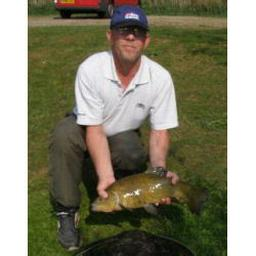

In [4]:
dataloader = DataLoader(ds, collate_fn=collate_fn, batch_size=4)
batch = next(iter(dataloader))
print(batch["label"][0])
batch["image"][0]

## Training

In [5]:
def train(model, dataset, batch_size, lr, weight_decay=0, penalty=0):
    torch.amp.autocast("cuda", True)

    dataloader = DataLoader(dataset, collate_fn=collate_fn, shuffle=True, batch_size=batch_size)
    
    num_steps = len(dataloader)
    pbar = tqdm(range(num_steps))
    
    optimizer = torch.optim.Adam(model.sae.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, total_steps=num_steps)
    
    history = defaultdict(list)
        
    for batch in dataloader:
        optimizer.zero_grad()
        mse_loss, l1_loss, l0_metric = model.forward(batch)
        loss = mse_loss + l1_loss*penalty
        loss.backward()
        optimizer.step()
        scheduler.step()
    
        history["mse_loss"].append(mse_loss.item())
        history["l1_loss"].append(l1_loss.item())
        history["loss"].append(loss.item())
        history["l0_loss"].append(l0_metric.item())
        pbar.set_description("LR: {:.4e} Loss: {:.6f} MSE: {:.6f} L1: {:.6f} L0: {:.6f}".format(
            optimizer.param_groups[0]["lr"], 
            loss.item(), mse_loss.item(), l1_loss.item(), l0_metric.item()))
        pbar.update(1)
    return history

### Hook at self-attention

In [6]:
model = SAEonCLIP(
    clip_model="openai/clip-vit-base-patch16", 
    hook_layer=10, 
    hook_module="self_attn", 
    expansion_factor=64
)
history = train(
    model, 
    ds, 
    batch_size=16, 
    lr=4e-4, 
    weight_decay=0.0001, 
    penalty=8e-5
)
torch.save(model.sae.state_dict(), "clip-vit-base-patch16_sae.pt")

  0%|          | 0/80073 [00:00<?, ?it/s]

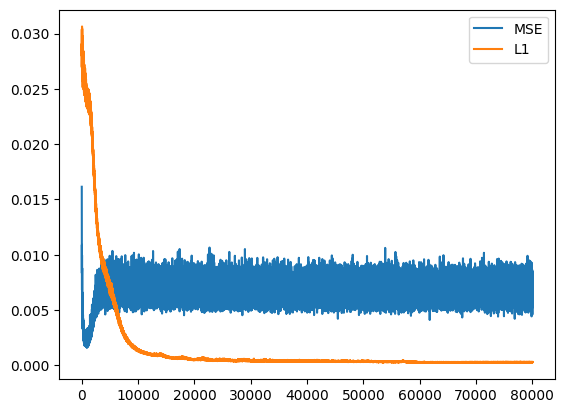

In [10]:
plt.plot(history["mse_loss"], label="MSE")
plt.plot(history["l1_loss"], label="L1")
plt.legend();

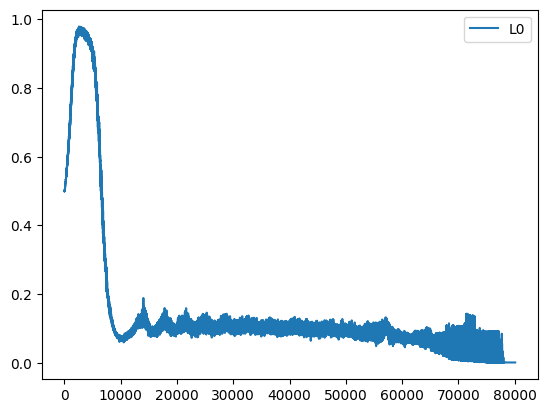

In [11]:
plt.plot(history["l0_loss"], label="L0")
plt.legend();

### Hook at MLP

In [6]:
model = SAEonCLIP(
    clip_model="openai/clip-vit-base-patch16", 
    hook_layer=10, 
    hook_module="mlp", 
    expansion_factor=64
)
history = train(
    model, 
    ds, 
    batch_size=16, 
    lr=4e-4, 
    weight_decay=0.0001, 
    penalty=8e-5
)
torch.save(model.sae.state_dict(), "clip-vit-base-patch16_sae-v2.pt")

  0%|          | 0/80073 [00:00<?, ?it/s]

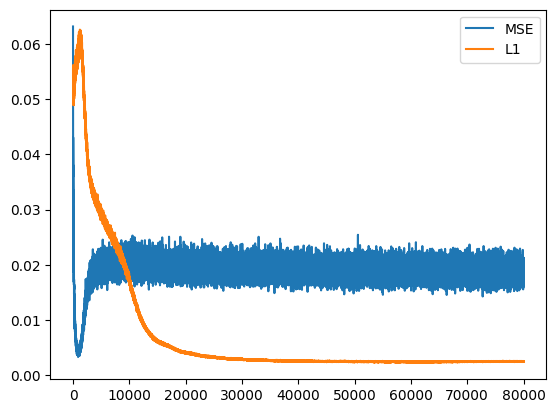

In [7]:
plt.plot(history["mse_loss"], label="MSE")
plt.plot(history["l1_loss"], label="L1")
plt.legend();

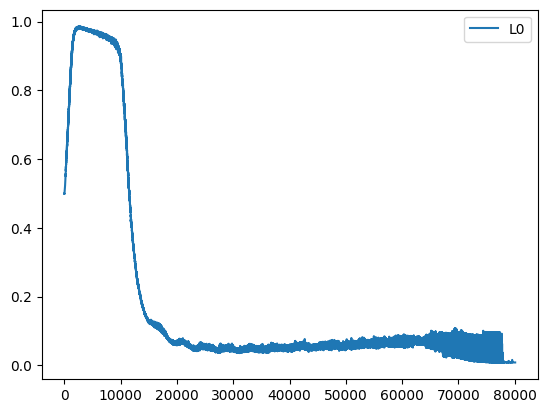

In [8]:
plt.plot(history["l0_loss"], label="L0")
plt.legend();

### Geom. Decoder Bias

In [6]:
model = SAEonCLIP(
    clip_model="openai/clip-vit-base-patch16", 
    hook_layer=10, 
    hook_module="mlp", 
    expansion_factor=64,
    geom_dec_bias=True
)
history = train(
    model, 
    ds, 
    batch_size=16, 
    lr=4e-4, 
    weight_decay=0.0001, 
    penalty=8e-5
)
torch.save(model.sae.state_dict(), "clip-vit-base-patch16_sae-v3.pt")

  0%|          | 0/80073 [00:00<?, ?it/s]

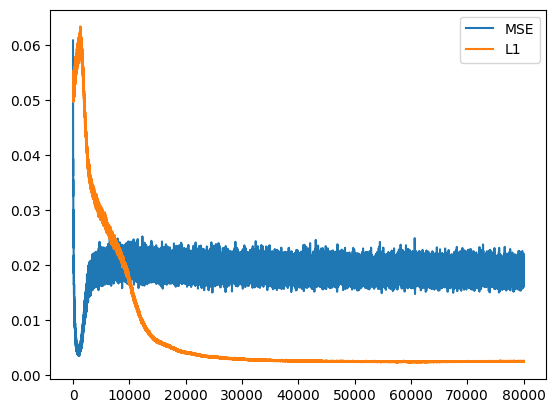

In [7]:
plt.plot(history["mse_loss"], label="MSE")
plt.plot(history["l1_loss"], label="L1")
plt.legend();

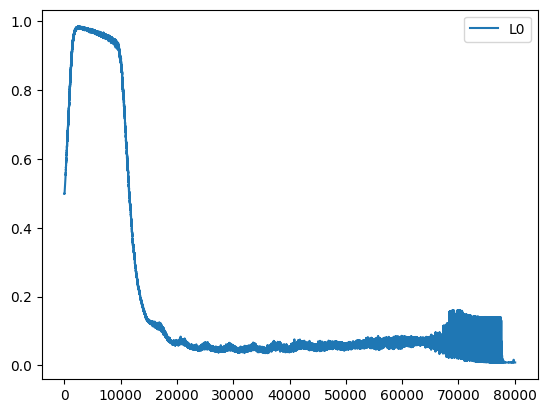

In [8]:
plt.plot(history["l0_loss"], label="L0")
plt.legend();

## Validation

In [9]:
def evaluate(model, dataset, batch_size=16):
    dataloader = DataLoader(dataset, collate_fn=collate_fn, batch_size=batch_size)
    statistics = defaultdict(list)
    
    for batch in tqdm(dataloader):
        with torch.no_grad():
            representation, activations, reconstruction = model.encode(batch)

        mse_loss = compute_mse_loss(representation, reconstruction).cpu()
        sparsity = compute_sparsity(activations).cpu()
        mean_activation_value = compute_mean_activation_value(activations).cpu()
        label_entropy = compute_label_entropy(activations).cpu()
    
        statistics["mse_loss"].append(mse_loss)
        statistics["sparsity"].append(sparsity)
        statistics["mean_activation_value"].append(mean_activation_value)
        statistics["label_entropy"].append(label_entropy)

    statistics = {k: torch.cat(v) for k,v in statistics.items()}
    print(*[f"{k}: {v.mean()}" if k != "label_entropy" else f"{k}: {v.sum()}" \
            for k,v in statistics.items()], sep="\n")

    return statistics


def plot_stat(statistics):
    plt.scatter(
        statistics["sparsity"].log10(), statistics["mean_activation_value"].log10(), 
        c=statistics["label_entropy"]
    )
    plt.xlabel("Log10 Activated Frequency")
    plt.ylabel("Log10 Mean Activation Value")
    cbar = plt.colorbar()
    cbar.set_label("Label Entropy")
    plt.show()

In [4]:
model = SAEonCLIP(
    clip_model="openai/clip-vit-base-patch16", 
    hook_layer=10, 
    hook_module="self_attn", 
    expansion_factor=64
)
model.sae.load_state_dict(torch.load("clip-vit-base-patch16_sae.pt"))
model.eval()
ds = datasets.load_dataset("benjamin-paine/imagenet-1k-256x256", split="train")
statistics = evaluate(model, ds)

Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/80073 [00:00<?, ?it/s]

mse_loss: 0.006715906318277121
sparsity: 0.0010440724436193705
mean_activation_value: 0.28365933895111084
label_entropy: 221834.28125


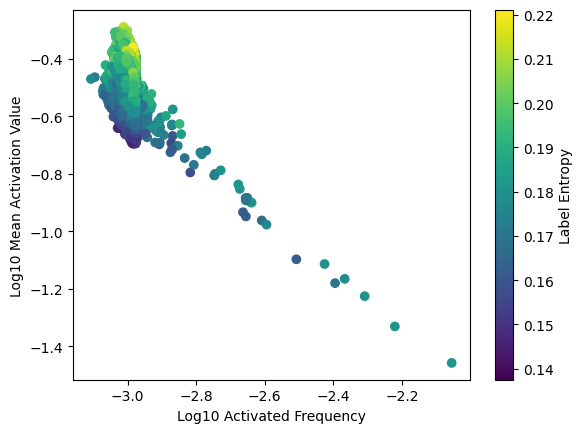

In [5]:
plot_stat(statistics)

In [6]:
ds = datasets.load_dataset("benjamin-paine/imagenet-1k-256x256", split="validation")
statistics = evaluate(model, ds)

Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

mse_loss: 0.006767171435058117
sparsity: 0.0010440995683893561
mean_activation_value: 0.2843976616859436
label_entropy: 8649.271484375


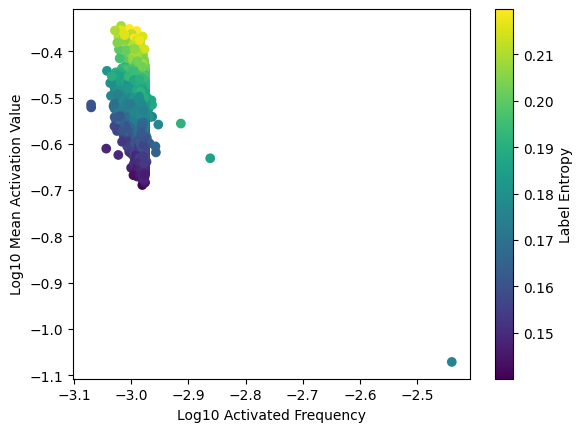

In [7]:
plot_stat(statistics)

In [11]:
model = SAEonCLIP(
    clip_model="openai/clip-vit-base-patch16", 
    hook_layer=10, 
    hook_module="mlp", 
    expansion_factor=64
)
model.sae.load_state_dict(torch.load("clip-vit-base-patch16_sae-v2.pt"))
model.eval()
ds = datasets.load_dataset("benjamin-paine/imagenet-1k-256x256", split="train")
statistics = evaluate(model, ds)

  0%|          | 0/80073 [00:00<?, ?it/s]

mse_loss: 0.018661558628082275
sparsity: 0.008604303002357483
mean_activation_value: 0.2901357412338257
label_entropy: 221948.125


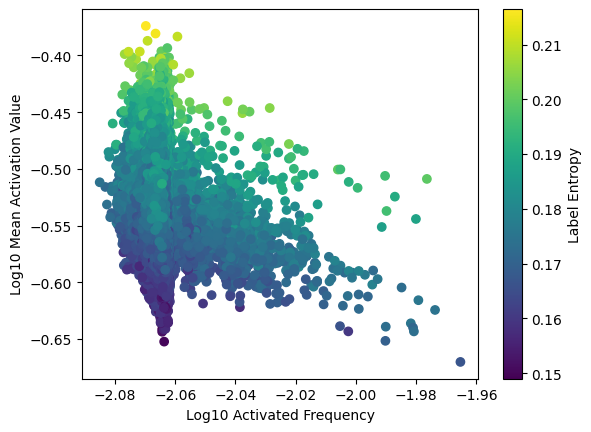

In [12]:
plot_stat(statistics)

In [13]:
ds = datasets.load_dataset("benjamin-paine/imagenet-1k-256x256", split="validation")
statistics = evaluate(model, ds)

Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

mse_loss: 0.01877015084028244
sparsity: 0.008604477159678936
mean_activation_value: 0.29085999727249146
label_entropy: 8660.4921875


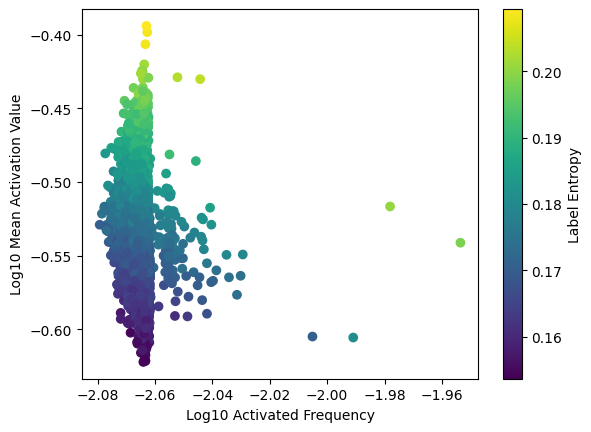

In [14]:
plot_stat(statistics)

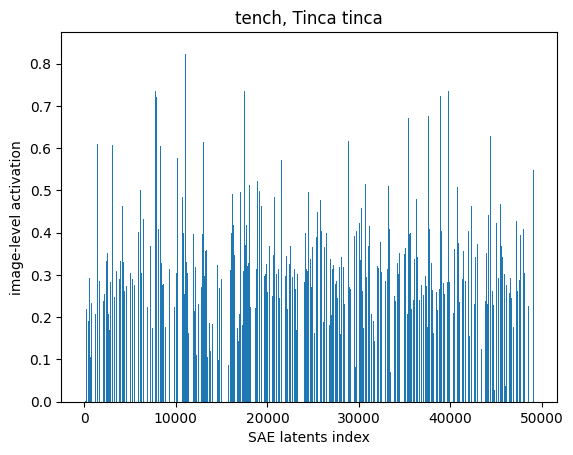

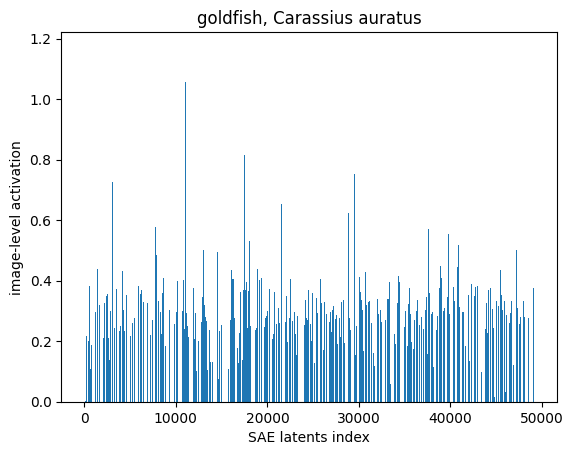

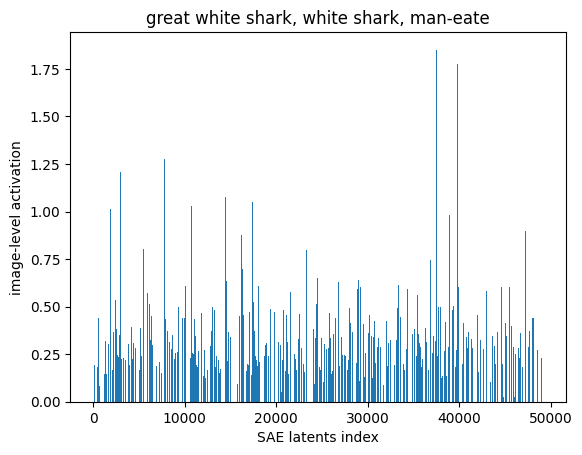

In [15]:
for label, class_name in enumerate(ds.features["label"].names[:3]):
    dataloader = DataLoader(
        ds.select(torch.where(torch.tensor(ds["label"]) == label)[0]), 
        collate_fn=collate_fn, 
        batch_size=1
    )
    batch = next(iter(dataloader))
    with torch.no_grad():
        representation, activations, reconstruction = model.encode(batch)

    plt.bar(range(49152), activations.mean(1).squeeze().detach().cpu().numpy(), width=100)
    plt.title(class_name[:40])
    plt.xlabel("SAE latents index")
    plt.ylabel("image-level activation")
    plt.show()

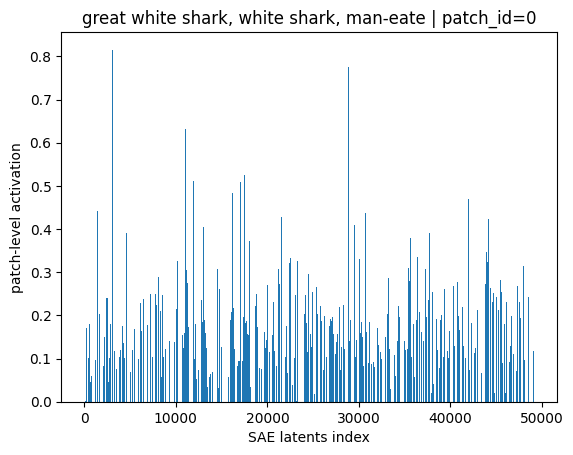

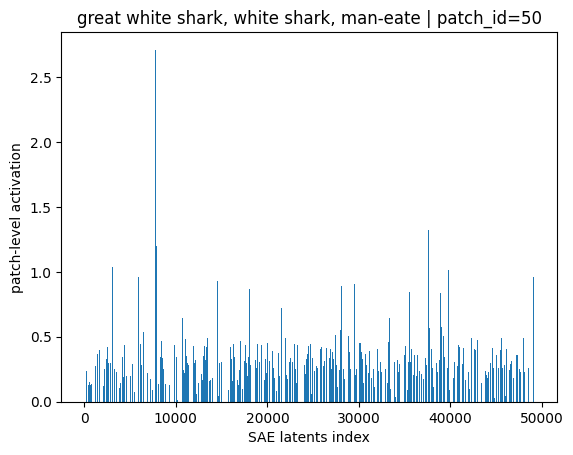

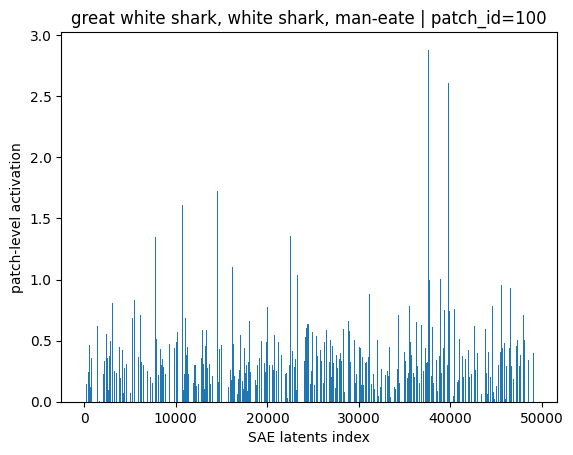

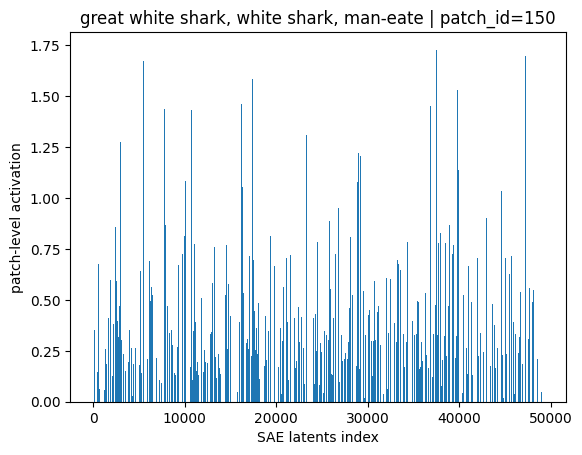

In [16]:
for i, patch in enumerate(activations[0]):
    if not i % 50:
        plt.bar(range(49152), patch.detach().cpu().numpy(), width=100)
        plt.title(f"{batch['label'][0][:40]} | patch_id={i}")
        plt.xlabel("SAE latents index")
        plt.ylabel("patch-level activation")
        plt.show()

In [10]:
model = SAEonCLIP(
    clip_model="openai/clip-vit-base-patch16", 
    hook_layer=10, 
    hook_module="mlp", 
    expansion_factor=64,
    geom_dec_bias=True
)
model.sae.load_state_dict(torch.load("clip-vit-base-patch16_sae-v3.pt"))
model.eval()
ds = datasets.load_dataset("benjamin-paine/imagenet-1k-256x256", split="train")
statistics = evaluate(model, ds)

  0%|          | 0/80073 [00:00<?, ?it/s]

mse_loss: 0.018654385581612587
sparsity: 0.008384749293327332
mean_activation_value: 0.29682379961013794
label_entropy: 221948.40625


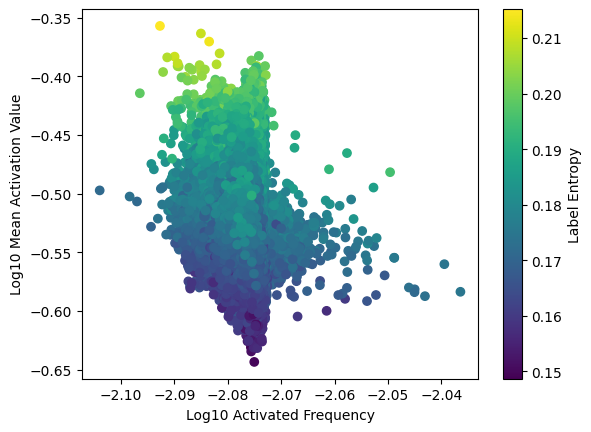

In [11]:
plot_stat(statistics)

In [12]:
ds = datasets.load_dataset("benjamin-paine/imagenet-1k-256x256", split="validation")
statistics = evaluate(model, ds)

Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

mse_loss: 0.018763743340969086
sparsity: 0.008384821005165577
mean_activation_value: 0.2975737452507019
label_entropy: 8660.541015625


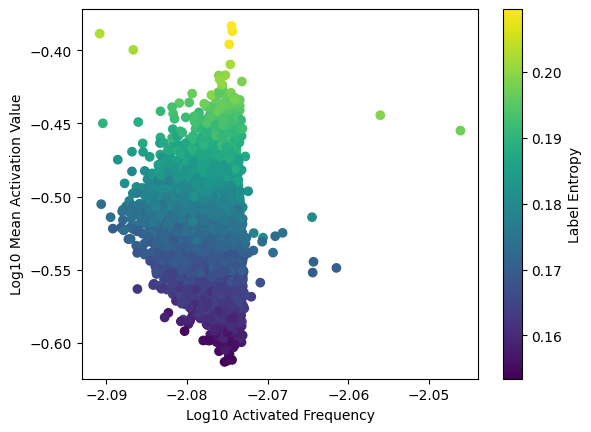

In [13]:
plot_stat(statistics)

## Image-level activations

In [3]:
def agg_image(model, dataset, batch_size=16):
    dataloader = DataLoader(dataset, collate_fn=collate_fn, batch_size=batch_size)
    image_activations = torch.zeros((dataset.num_rows, model.sae.encoder.out_features), dtype=torch.float32)
    
    for i, batch in enumerate(tqdm(dataloader)):
        with torch.no_grad():
            representation, activations, reconstruction = model.encode(batch)
        
        image_activations[i*batch_size :  i*batch_size + activations.shape[0], :] += activations.mean(1).cpu()
    return image_activations

In [4]:
ds = datasets.load_dataset("benjamin-paine/imagenet-1k-256x256", split="validation")

Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

In [4]:
DATA_DIR = "data/vanilla"
os.makedirs(DATA_DIR, exist_ok=True)

model = SAEonCLIP(
    clip_model="openai/clip-vit-base-patch16", 
    hook_layer=10, 
    hook_module="self_attn", 
    expansion_factor=64
)
model.sae.load_state_dict(torch.load("clip-vit-base-patch16_sae.pt"))
model.eval()
image_activations = agg_image(model, ds)
sp.sparse.save_npz(f"{DATA_DIR}/image_activations.npz", sp.sparse.csc_matrix(image_activations.numpy()))
image_neurons = image_activations.nonzero()
torch.save(image_neurons, f"{DATA_DIR}/image_neurons.pt")

Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

In [5]:
DATA_DIR = "data/vanilla-v2"
os.makedirs(DATA_DIR, exist_ok=True)

model = SAEonCLIP(
    clip_model="openai/clip-vit-base-patch16", 
    hook_layer=10, 
    hook_module="mlp", 
    expansion_factor=64
)
model.sae.load_state_dict(torch.load("clip-vit-base-patch16_sae-v2.pt"))
model.eval()
image_activations = agg_image(model, ds)
sp.sparse.save_npz(f"{DATA_DIR}/image_activations.npz", sp.sparse.csc_matrix(image_activations.numpy()))
image_neurons = image_activations.nonzero()
torch.save(image_neurons, f"{DATA_DIR}/image_neurons.pt")

  0%|          | 0/3125 [00:00<?, ?it/s]

In [3]:
DATA_DIR = "data/vanilla-v2"
image_activations = torch.tensor(sp.sparse.load_npz(f"{DATA_DIR}/image_activations.npz").toarray())
image_neurons = torch.load(f"{DATA_DIR}/image_neurons.pt")

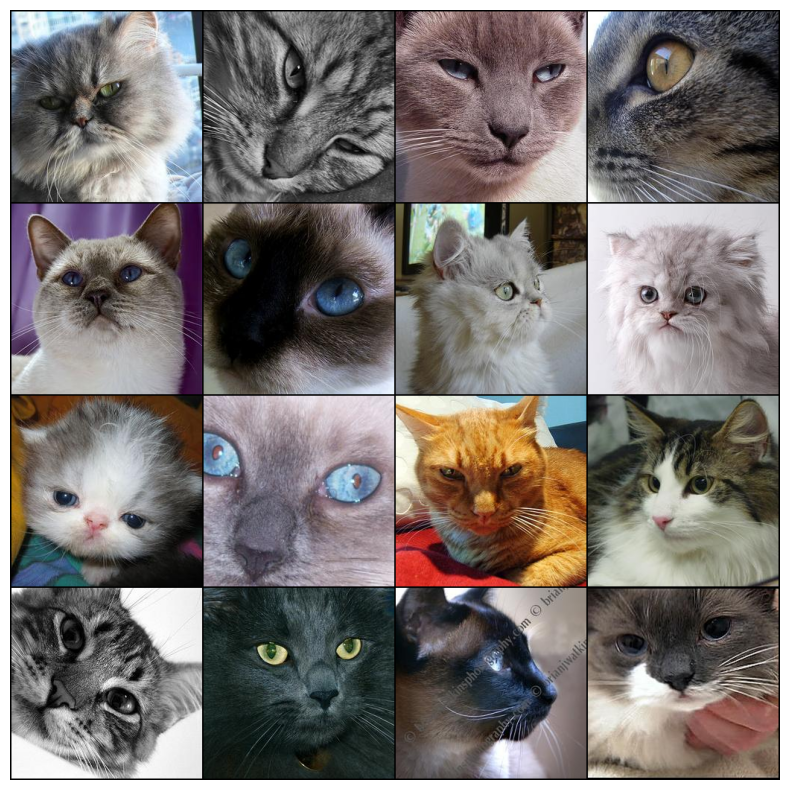

In [6]:
neuron = 46041
image_ids = image_neurons[image_neurons[:,1] == neuron][:,0]
neuron_activations = image_activations[image_ids.tolist(), neuron]
indices = image_ids[neuron_activations.topk(16).indices]
batch = ds.select(indices)
fig = plt.figure(figsize=(10,10))
plt.imshow(make_grid(batch, nrow=4))
plt.axis("off")
plt.show()

In [7]:
batch_activations = image_activations[indices, :]
print(f"Log10 sparsity: {compute_sparsity(batch_activations).mean().log10()}")
print(f"Mean activation value: {batch_activations.mean()}")
print(f"Label entropy: {compute_label_entropy(batch_activations).sum()}")

Log10 sparsity: -2.059020757675171
Mean activation value: 0.0025482287164777517
Label entropy: 2.772176742553711


In [5]:
DATA_DIR = "data/vanilla-v3"
os.makedirs(DATA_DIR, exist_ok=True)

model = SAEonCLIP(
    clip_model="openai/clip-vit-base-patch16", 
    hook_layer=10, 
    hook_module="mlp", 
    expansion_factor=64,
    geom_dec_bias=True
)
model.sae.load_state_dict(torch.load("clip-vit-base-patch16_sae-v3.pt"))
model.eval()
image_activations = agg_image(model, ds)
sp.sparse.save_npz(f"{DATA_DIR}/image_activations.npz", sp.sparse.csc_matrix(image_activations.numpy()))
image_neurons = image_activations.nonzero()
torch.save(image_neurons, f"{DATA_DIR}/image_neurons.pt")

  0%|          | 0/3125 [00:00<?, ?it/s]

## Patch-level activations

In [6]:
def agg_token(model, dataset, batch_size=16):
    dataloader = DataLoader(dataset, collate_fn=collate_fn, batch_size=batch_size)
    num_tokens = model.clip.vision_model.embeddings.position_embedding.num_embeddings
    activation_dim = model.sae.encoder.out_features
    token_activations = torch.zeros((num_tokens, activation_dim), dtype=torch.float32)
    
    for i, batch in enumerate(dataloader):
        with torch.no_grad():
            representation, activations, reconstruction = model.encode(batch)
        
        token_activations += activations.sum(0).cpu()
    token_activations /= len(dataset)
    return token_activations


def agg_label(model, dataset, data_dir):
    for label, class_name in enumerate(tqdm(dataset.features["label"].names[:-1])):
        subset = dataset.select(torch.where(torch.tensor(dataset["label"]) == label)[0])
        token_activations = agg_token(model, subset, batch_size=16)
        os.makedirs(f"{data_dir}/token_activations", exist_ok=True)
        sp.sparse.save_npz(
            f"{data_dir}/token_activations/{label}.npz", 
            sp.sparse.csc_matrix(token_activations.numpy())
        )


def topk_neurons(data_dir, k=10):
    num_tokens = sp.sparse.load_npz(f"{data_dir}/token_activations/0.npz").shape[0]
    token_top_neurons = torch.zeros((1000, num_tokens, k), dtype=torch.int32)
    
    for f in tqdm(os.listdir(f"{data_dir}/token_activations")):
        token_activations = sp.sparse.load_npz(f"{data_dir}/token_activations/{f}")
        activations, indices = torch.tensor(token_activations.toarray()).topk(k,1)
        token_top_neurons[int(f.split(".")[0]),:,:] += indices
    
    torch.save(token_top_neurons, f"{data_dir}/token_top_neurons.pt")

In [4]:
ds = datasets.load_dataset("benjamin-paine/imagenet-1k-256x256", split="validation")

Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

In [5]:
DATA_DIR = "data/vanilla"

model = SAEonCLIP(
    clip_model="openai/clip-vit-base-patch16", 
    hook_layer=10, 
    hook_module="self_attn", 
    expansion_factor=64
)
model.sae.load_state_dict(torch.load("clip-vit-base-patch16_sae.pt"))
model.eval()
agg_label(model, ds, DATA_DIR)
topk_neurons(DATA_DIR)

Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
DATA_DIR = "data/vanilla-v2"

model = SAEonCLIP(
    clip_model="openai/clip-vit-base-patch16", 
    hook_layer=10, 
    hook_module="mlp", 
    expansion_factor=64
)
model.sae.load_state_dict(torch.load("clip-vit-base-patch16_sae-v2.pt"))
model.eval()
agg_label(model, ds, DATA_DIR)
topk_neurons(DATA_DIR)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
DATA_DIR = "data/vanilla-v3"

model = SAEonCLIP(
    clip_model="openai/clip-vit-base-patch16", 
    hook_layer=10, 
    hook_module="mlp", 
    expansion_factor=64,
    geom_dec_bias=True
)
model.sae.load_state_dict(torch.load("clip-vit-base-patch16_sae-v3.pt"))
model.eval()
agg_label(model, ds, DATA_DIR)
topk_neurons(DATA_DIR)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]